# Introduction

<b>Web crawling</b> is sometimes a confusing term, as it is sometimes used interchangably with web scraping. In general, web crawing is part of the process of gathering data from webpages, and the term refers to the process of navigating through URLs on a website or set of websites to get pages. In contrast, web scraping is the next step where you take the content of the pages to use for parsing. 
<br>
<br>Crawling is used for numerous purposes. Search engines and content aggregators are the most obvious examples, but other use cases include making price comparison sites, competitor research (prices, products, etc), or sentiment analysis on news outlets or social media. An example of a business built on web scraping is https://www.airdna.co, which scrapes listings from Airbnb and Homeaway to help people who rent out their properties to run their business.
<br>
<br>We are using <b>Scrapy</b>, a web scraping library that also has the tools to make web crawlers (spiders). 
<br>
<br>Scrapy is actually prettys imilar to bs4, which we used in class. However, there are some key differences:
<br>
1) Scrapy is more robust: bs4 is primarily used for parsing data and needs to be paired with the requests library for scraping. Scrapy is specifically made for scraping, so it has more tools to navigate through many pages quickly. 

2) Going off of that, Scrapy is not just for scraping. It provides tools for the full pipeline in one tool, from making a spider to scraping to parsing.

3) It's also faster than bs4 due to requests being processed <b>asynchronously</b>, as in, a request does not have to finish before another one starts.


# Tutorial Content

Installing libraries
<br>Understanding the Scrapy Workflow
<br>Understanding Robots.txt
<br>Spider - Requests
<br>Understanding Xpaths
<br>Spider - Parsing
<br>Items
<br>Item Pipeline
<br>Using Scraped Data
<br>Project Ideas
<br>Summary and References

# Installing Libraries

In [ ]:
pip install scrapy

In [ ]:
pip install matplotlib

In [1]:
### imports
import scrapy
from scrapy.crawler import CrawlerProcess
import re
from scrapy import settings
import json
import os

Before we start this project, we are running this code. This is to fix an incompatibility between Scrapy, matplotlib, and Jupyter Notebook, and is not relevant if you are running Scrapy in the command line or from a .py file. The code is from <a href="https://stackoverflow.com/a/43015816">here</a> and the problem is described <a href='https://stackoverflow.com/a/44086709'>here</a>.

Non Gui backends are: ['agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
Gui backends I will test for ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
testing GTK3Agg
     GTK3Agg Is Available
Using .....  agg
testing GTK3Cairo
     GTK3Cairo Not found
testing MacOSX
     MacOSX Not found
testing nbAgg
     nbAgg Is Available


<IPython.core.display.Javascript object>


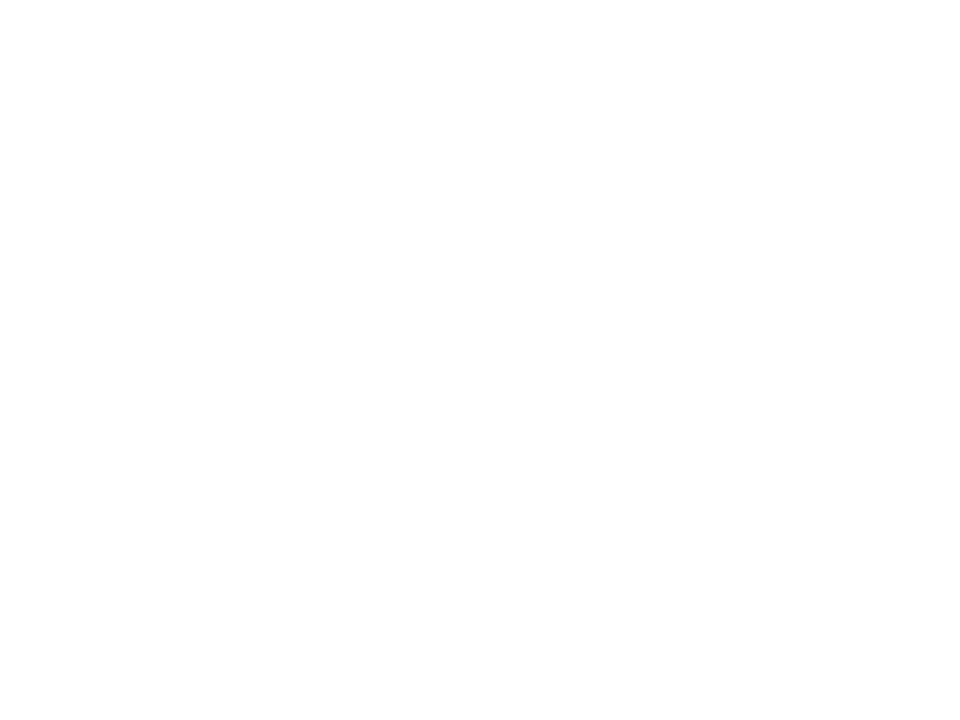

Using .....  nbAgg
testing Qt4Agg
     Qt4Agg Not found
testing Qt4Cairo
     Qt4Cairo Not found
testing Qt5Agg
     Qt5Agg Not found
testing Qt5Cairo
     Qt5Cairo Not found
testing TkAgg
     TkAgg Not found
testing TkCairo
     TkCairo Not found
testing WebAgg
     WebAgg Is Available
Press Ctrl+C to stop WebAgg server
     WebAgg Not found
testing WX
     WX Not found
testing WXAgg
     WXAgg Not found
testing WXCairo
     WXCairo Not found


Traceback (most recent call last):
  File "/home/xluo1/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/xluo1/.local/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/home/xluo1/.local/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


In [2]:
import matplotlib
gui_env = [i for i in matplotlib.rcsetup.interactive_bk]
non_gui_backends = matplotlib.rcsetup.non_interactive_bk
print ("Non Gui backends are:", non_gui_backends)
print ("Gui backends I will test for", gui_env)
for gui in gui_env:
    print ("testing", gui)
    try:
        matplotlib.use(gui,warn=False, force=True)
        from matplotlib import pyplot as plt
        print ("    ",gui, "Is Available")
        plt.plot([1.5,2.0,2.5])
        fig = plt.gcf()
        fig.suptitle(gui)
        plt.show()
        print ("Using ..... ",matplotlib.get_backend())
    except:
        print ("    ",gui, "Not found")

# Creating a Spider
In this project, we will be getting data on video game livestreams from Youtube. We will need to crawl the livestreams page with a spider, scrape each video for information, parse, download, and analyze the data. The first step is to create a spider.
<br>
<br>To start, we need to make a spider object. Spiders in general will have two functions- start_requests(), which is called when the spider begins crawling and specifies instructions on how the spider should crawl, and parse(self) which is called from start_requests() to parse each page the spider crawls on.
<br><br>
First, we will start with start_requests(). The structure of start_requests() should be a url or list of urls to crawl on and a yield keyword with a request that indicates with parse function to use on the request. ytURL is the url we are going to scrape to find links to livestreams. scrapy.Request() is essentially tellin the spider to make a request of ytURL, then feed the output of that request into parseLivePage(), our parse function.
<br><br>One unfamiliar element of the start_requests() function is the yield keyword. This tutorial will cover yield in the next function with a more illustrative example.

```python
def start_requests(self):
    # initiates spider
    ytURL = 'https://www.youtube.com/gaming/live'
    yield scrapy.Request(url=ytURL, callback=self.parseLivePage)
    ```

# Aside: Is Web Scraping Legal?
Yes.
<br><br>Basically, the rules for scrapy vary by website. If you want to check if a website allows scraping, you should visit their /robots.txt, which is a page that details who is allowed to scrape and what pages they are allowed on. To get to this page, just append /robots.txt to the website's url (for example, you would change website.com to website.com/robots.txt).
<br><br>After getting to that page, you should look for the line "User-agent: *", which has rules for all spiders. Underneath, there should be a list of directories that are allowed or disallowed. A "/" with nothing following means the entire website.
<br><br>
Read more <a href="https://www.robotstxt.org/robotstxt.html">here</a>.
<br><br>
Many sites (Amazon, LinkedIn, etc) disallow many or all of their pages. Will you get in trouble for not following these rules? Honestly for this project, you will probably not be noticed because it's on such a small scale. However, I do want to follow rules for this assignment, so I chose a site that had a relatively lenient scraping policy: Youtube.

# Parse Function
Our parse function is called parseLivePage(). Notice this function name is not a keyword, but start_requests() is.
This function essentially does similar things to what one would use bs4 for- finding unique elements on a page and using them as reference to grab elements to use (in this case, links to individual streams). After that, we are doing the same thing we did in start_requests() - crawl through those links and parse the individual stream's pages.

```python
def parseLivePage(self, response):
    # Currently on the page with all livestreams 
    # Get URLs of all streams on this page
    vidURLS = []
    titles = response.xpath('//*[contains(@class,"yt-lockup-title")]') 
    for vid in titles:
        link = vid.xpath('.//a/@href').get() # must have . at beginning to search WITHIN this selector!
        link = "https://www.youtube.com" + link  #MUST have https
        vidURLS.append(link)
    for link in vidURLS:
        streamItem = scrapy.Request(url=link, callback=self.parseVid)
        yield streamItem
```

# Yield 
This example is where yield is more relevant. 
<br><br>Yield acts similarly to a return statement, but instead of returning a string, integer, etc, it returns the function as a generator. A generator is an iterable (like a list) that can only be run through once. Therefore, generators are used to read many values without needing to store them in memory, which is why they are useful for spiders.
<br><br>
In Scrapy, yield is also used to return values without ending the function. If you change yield in parseLivePage() to return, it only operates on the first video in the livestreams page. With yield, it can return all the pages to start_requests, which the spider can push to the pipeline.
<br><br>
To read more about the use of yield in Scrapy, go <a href="https://stackoverflow.com/a/45120309">here</a>.
To read more about how yield works, go <a href="https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do">here</a>.

# Parsing
We will parse the html using Xpath. Xpath is a syntax that can be used to navigate an html document. First, you use the [contains(@type of tag, "value of tag")] syntax to find an identifier, and use that as a reference to navigate the html to find the element you need. You can also start with / to start navigating from the root node. 
<br><br>Xpath is pretty self-explanatory. For example, take this statement:
```
///*[contains(@class, "video-thumb  yt-thumb yt-thumb-48")]/span/span/img/@alt
```
This means to start at the tag that contains <class = "video-thumb  yt-thumb yt-thumb-48">, then go the first span tag nested in this tag, then the first span tag again, then the first image tag, then get the value of the alt attribute in that image tag. 
One note is that .get() gets the content insdie a tag, while @ gets the content in the attribute. So for example, for:
```
<a href="google.com">link</a>
```
@href will get "google.com" while .get() gets "link".
<br><br>
If you want to verify your syntax, you can go to inspect element and search with your syntax. It should highlight the code you want to get!
<br><br>
The last thing to notice is that all the information is put into a Stream object. We will go into that next.

   ```python 
    def parseVid(self, response):
        
        # get url
        url = response.url

        # get title
        title = response.xpath('//*/span[contains(@class, "watch-title")]/@title').get()
        
        # get streamer
        streamer = response.xpath('///*[contains(@class, "video-thumb  yt-thumb yt-thumb-48")]/span/span/img/@alt').get()
        
        # get number views
        views = response.xpath('string(//*[contains(@class, "watch-view-count")])').get()
        
        
        # get number likes
        likes = response.xpath('string(//*[contains(@class,"yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-like-button like-button-renderer-like-button-clicked yt-uix-button-toggled  hid yt-uix-tooltip")]/span)').get()
      
        
        # get number dislikes
        dislikes = response.xpath('string(//*[contains(@class,"yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-dislike-button like-button-renderer-dislike-button-clicked yt-uix-button-toggled  hid yt-uix-tooltip")]/span)').get()
        
        # get desc
        desc = response.xpath('string(//*[contains(@id, "eow-description")])').get()
        
        # add to df
        streamItem = Stream(url = url, title = title, streamer = streamer, views = views, likes = likes, dislikes = dislikes, desc = desc)
        return streamItem
    ```

That completes our spider object! Below is the entire spider, with just a few more elements which I will explain.
<br><br>
"name": All spiders are required to have a name. This is to identify spiders when there is more than one in a Scrapy project, and is more relevant when running Scrapy in the command line. 
<br><br>"custom_settings": This identifies which pipeline the spider uses, which we will also get more into later. You can have multiple pipelines, and the number associated with each pipeline's path in the dictionary indicates the order in which the pipelines are run.

In [3]:
os.chmod("streams.jl", 436) # My computer needs to have permission to access any files
os.chmod("youtubespider.py", 436)

class ytSpider(scrapy.Spider):
    name = "yt" # uniquely IDs each spider in a project, more relevant when you run startproject and get all the files but we ... aren't doin that here
        
    custom_settings = {'ITEM_PIPELINES':{'youtubespider.StreamPipeline':0}}

    def start_requests(self):
        # initiates spider
        ytURL = 'https://www.youtube.com/gaming/live'
        yield scrapy.Request(url=ytURL, callback=self.parseLivePage)
       
    def parseLivePage(self, response):
        # Currently on the page with all livestreams 
        # Get URLs of all streams on this page
        vidURLS = []
        titles = response.xpath('//*[contains(@class,"yt-lockup-title")]') 
        for vid in titles:
            link = vid.xpath('.//a/@href').get() # must have . at beginning to search WITHIN this selector!
            link = "https://www.youtube.com" + link  #MUST have https
            vidURLS.append(link)
        for link in vidURLS:
            streamItem = scrapy.Request(url=link, callback=self.parseVid)
            yield streamItem
            
        
    def parseVid(self, response):
        
        # get url
        url = response.url

        # get title
        title = response.xpath('//*/span[contains(@class, "watch-title")]/@title').get()
        
        # get streamer
        streamer = response.xpath('///*[contains(@class, "video-thumb  yt-thumb yt-thumb-48")]/span/span/img/@alt').get()
        
        # get number views
        views = response.xpath('string(//*[contains(@class, "watch-view-count")])').get()
        
        
        # get number likes
        likes = response.xpath('string(//*[contains(@class,"yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-like-button like-button-renderer-like-button-clicked yt-uix-button-toggled  hid yt-uix-tooltip")]/span)').get()
        
        # get number dislikes
        dislikes = response.xpath('string(//*[contains(@class,"yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-dislike-button like-button-renderer-dislike-button-clicked yt-uix-button-toggled  hid yt-uix-tooltip")]/span)').get()
        
        # get desc
        desc = response.xpath('string(//*[contains(@id, "eow-description")])').get()
        
        # add to df
        streamItem = Stream(url = url, title = title, streamer = streamer, views = views, likes = likes, dislikes = dislikes, desc = desc)
        return streamItem

# Items
An item basically represents one unit of information that you want to scrape. In our case, this unit is one livestream and the information associated with it (streamer, url, title, description, etc). Each item will be stored as one row in a database or one JSON object.<br><br>
Declaring an item is simple- it is declaring a scrapy.Item object and setting up the fields ike so:

``` python
### Stream object

class Stream(scrapy.Item):
    url = scrapy.Field()
    title = scrapy.Field()
    streamer = scrapy.Field()
    views = scrapy.Field()
    likes = scrapy.Field()
    dislikes = scrapy.Field()
    desc = scrapy.Field()
   ```

# Pipeline
The pipeline is the last component of this project and is used to process data before storing it in a database or JSON file. A spider can be connected to multiple pipelines, each used for a different step in the data processing/cleaning process.
<br><br>
This is an optional step and, especially for this project, this processing could have happened in the spider. However, it's included here for example purposes. For our project, the goal is to clean up the data and then store them in a JSON file. 
<br><br>
Pipelines have three functions, open_spider(), close_spider(), and process_item(). open_spider() and close_spider() are called when the spider starts and stops respectively (and also opens and closes the JSON file).
<br><br>
In process_item(), we are simply replacing any errored numbers with N/A and getting a rid of commas in numbers.


```python
### Item Pipeline

class StreamPipeline(object):
    
    def open_spider(self, spider):
        self.file = open('streams.jl', 'a')
   

    def close_spider(self, spider):
        self.file.close()
        

    def process_item(self, item, spider):
        item['views'] = item['views'][:-6]
            
        try:
            item['views'] = int(re.sub(",","",item['views']))
            
        except: 
            item['views'] = "N/A" # if html doesn't have this info
        
        
        try:
            item['dislikes'] = int(re.sub(",","",item['dislikes']))
        except:
            item['dislikes'] = "N/A"
        
        try:
            item['likes'] = int(re.sub(",","",item['likes']))
        except:
            item['likes'] = "N/A"
   
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item```

Pipelines aren't super hard to understand by themselves- the more difficult part is telling the spider to use a certain pipeline. In a normal project (as in, if everything was in a .py), the pipeline and spider would be in different files, and there would be a separate settings.py file with instructions for the spider. Scrapy also gives us an option to also indicate these settings directly in the spider, which is what we've done in this project (which is why we have the custom_settings variable in the spider).
<br><br>The spider can only find pipelines and item objects if they are in a .py file. So, there is a separate .py file bundled with this notebook that the spider is using, but the code inside is the same as the pipeline and object code above.

# Running the Spider
When running the spider in a script, we use CrawlerProcess(). Here is where I will admit I found some bugs transferring the code from a .py file to Jupyter notebook so for clarity, I am including the bugs here:
<br><br>
1) process.start() runs the spider. If it's commented out in the .py, it doesn't run. However, the Jupyter version runs when process.start() is commented out, and runs twice when it is included. I couldn't figure out why that was the case, but commented out process.start() so the code would run.

2) For some reason, the spider is called twice. Basically, the spider opens, closed, and is opened again before raising an error. This means open_spider() is run first and last for this spider, which also means if open() is run with 'w', the spider will write to the file and then delete it. I am solving this error by having open_spider write 'a' inside the pipeline, but creating the file with 'w' b efore the spider is started. This happens on both the .py and Jupyter notebook


In [4]:
open('streams.jl', 'w') 
process = CrawlerProcess()
process.crawl(ytSpider)
# process.start(stop_after_crawl=True)
# The above line is required in .py version of spider, for some reason calls the function twice in the Jupyter notebook version

2019-10-13 21:56:51 [scrapy.utils.log] INFO: Scrapy 1.7.3 started (bot: scrapybot)
2019-10-13 21:56:51 [scrapy.utils.log] INFO: Versions: lxml 4.4.1.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.7.0, Python 3.6.8 (default, Jan 14 2019, 11:02:34) - [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]], pyOpenSSL 19.0.0 (OpenSSL 1.1.1c  28 May 2019), cryptography 2.7, Platform Linux-4.4.0-18362-Microsoft-x86_64-with-Ubuntu-18.04-bionic
2019-10-13 21:56:51 [scrapy.crawler] INFO: Overridden settings: {}
2019-10-13 21:56:51 [scrapy.extensions.telnet] INFO: Telnet Password: 835f4339c41f2732
2019-10-13 21:56:51 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2019-10-13 21:56:51 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 

2019-10-13 21:56:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=W2dnWmd_AnQ>
{'desc': '➤ Help Me Reach 3 Million Subscribers! '
         'https://www.youtube.com/user/thesmith...➤ Twitter: '
         'https://twitter.com/TheSmithPlays➤ Instagram: '
         'https://www.instagram.com/therealsmit...➤ Become a member of the '
         'channel HERE: https://www.youtube.com/channel/UCr6n...My sponsors:➤ '
         "Get 10% off GFuel with coupon code 'Smith' https://gfuel.com/",
 'dislikes': 2767,
 'likes': 79686,
 'streamer': 'TheSmithPlays',
 'title': 'Fortnite Chapter 2: ROCKET LAUNCH EVENT SEASON 10 FORTNITE LIVE!',
 'url': 'https://www.youtube.com/watch?v=W2dnWmd_AnQ',
 'views': 'N/A'}
2019-10-13 21:56:55 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=8NRLuUnpGYg>
{'desc': 'The faction war reaches its inevitable climax at the gates of '
         "Orgrimmar as Alliance soldiers stand together with Saurfang's rebels "
  

2019-10-13 21:56:55 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=0GFpPZi3AyM> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:55 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=a-d8_DA_ZGo>
{'desc': 'Jonesy arrives a bit late to the Battle Bus and makes a new '
         'friend.Play Fortnite Battle Royale, the completely free 100-player '
         'PvP mode. One giant map, A Battle Bus, Last one standing wins. ESRB '
         'Rating: Teen with Violence.Instagram: '
         'https://www.instagram.com/fortnite/Twitter: '
         'https://twitter.com/FortniteGameFacebook: '
         'https://www.facebook.com/FortniteGame/Learn More: '
         'https://www.epicgames.com/fortnite/en...',
 'dislikes': 3064,
 'likes': 130255,
 'streamer': 'Fortnite',
 'title': 'Fortnite Shorts - Bus Fulla Tomatoes',
 'url': 'https://www.youtube.com/watch?v=a-d8_DA_ZGo',
 'views': 2080389}
2019-10-13 21:56:55 [scrapy.core.scra

2019-10-13 21:56:55 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=HFRscoOkkb8> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:55 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=vza5XYJ4zZ8>
{'desc': "Thanks to Assassin's Creed for sponsoring this video!Want to win "
         'free Assassin’s Creed swag?  Sign up today at '
         "http://bit.ly/1TukEmFWatch the all new Assassin's Creed Syndicate "
         'gameplay walkthrough! http://bit.ly/1Tul3pgCheck us out  as we test '
         "our assassin skills on the Assassin's Creed experience at San Diego "
         'Comic Con! Subscribe for more Smosh ►► '
         'http://smo.sh/S2ndSubLUNCHTIME W/ MINIONS ►► '
         'http://smo.sh/SIB-DeArticulator-------------------------------------Hey '
         "it's our very own website: http://smosh.comOh and our Facebook page: "
         "http://facebook.com/smoshWant to know when we're filming and/or "
       

2019-10-13 21:56:56 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=9Oo9n89guRM> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:56 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=_Fk5F5NMaCQ> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:56 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=mY3qnyVXP5I>
{'desc': 'Today I show you how to make Minecraft Creeps! Inspired by '
         'ThinkGeeks April fools joke, I turn this hoax into real life! These '
         'creeps are perfect for Easter baskets and Minecraft parties!Check '
         'out Lydias Channel for behind the '
         'scenes!https://www.youtube.com/channel/UC-ol...// For the latest '
         'videos, Subscribe! http://bit.ly/iHasCupquakeYT //Minecraft Creeps - '
         'QUAKE N BAKEQuake n Bake Intro created by '
         'Red!https://twitter.com/redb15Quake N Bake Playlist - '
         'http://

2019-10-13 21:56:56 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=uXOdL7YJRNs> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:56 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=_Fk5F5NMaCQ>
{'desc': 'T-SHIRTS: '
         'http://goo.gl/cgOfHKTWITTER:http://twitter.com/andrewmfilmsFACEBOOK: '
         'http://www.facebook.com/andrewmfilmsOur protagonist finds a case '
         'full of magical golden lego bricks and is chased by gold-hungry '
         'minifigures.Directed/VFX by Andrew McMurryStarring Spencer '
         'WaldnerMusic by Matthew McMurry (http://haunteddisco.com/)Behind the '
         'scenes coming soon!',
 'dislikes': 18170,
 'likes': 126880,
 'streamer': 'Nukazooka',
 'title': 'LEGO Invasion!',
 'url': 'https://www.youtube.com/watch?v=_Fk5F5NMaCQ',
 'views': 67542127}
2019-10-13 21:56:56 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=3BVXynuhNfI> (referer: 

2019-10-13 21:56:57 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=JBwGcphS7iA> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:57 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=0OdXkZR0ip4>
{'desc': 'Intro music: “Spend My Time With You (Electro Swing Remix)” by 11 '
         'Acorn Lane https://www.youtube.com/watch?v=ep7Pr... iTunes: '
         'https://goo.gl/tOBN8L : Artist website: '
         'http://www.11acornlane.comGTA 5 Funny Moments playing GTA 5, GTA 5 '
         'Races, GTA 5 Stunts, GTA 5 Videos & more! Enjoyed GTA 5 Funny '
         'Moments? ► Subscribe: http://goo.gl/RnE9oB► Jelly Store: '
         'http://jellebay.comMy Friends:Jordi: http://goo.gl/vY6HZPJosh: '
         'http://goo.gl/j2SkqsVlogs: http://goo.gl/YCTW24Twitter: '
         'http://goo.gl/Jaadq5Facebook: http://goo.gl/k7XeI6Google+: '
         'http://goo.gl/yppMli► Follow me on:Instagram: '
         'https://goo.gl/r7VxC1Tw

2019-10-13 21:56:57 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=h9GqperW_Yg> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:57 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=-h4zTEwgCpQ>
{'desc': 'Facebook it! http://on.fb.me/fs9nvyTweet it! http://bit.ly/RTRLKartA '
         'harsh, gritty look at the world of Mario Kart in real life. Red '
         'shells mean business.Thanks to K1 Speed for allowing us use of their '
         'track! Check out their YouTube Channel at '
         'http://youtube.com/k1speedSpecial thanks to Corridor Digital ( '
         'http://youtube.com/corridordigital ) and Lifepreneur ( '
         'http://youtube.com/lifepreneur ) for VFX help and behind the scenes '
         "camera work! Couldn't have done it without those guys!---Check out "
         'our '
         'store!http://shop.rocketjump.comWebsite!http://rocketjump.com/Twitter!http://twitter.com/rocketjumptweethttp:/

2019-10-13 21:56:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=yvjiwqVoZtA> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=j01Kvi5Y7kg>
{'desc': 'Stream VODs, songs, music and oddities on my 2nd channel: '
         'https://www.youtube.com/channel/UCeUA...---Merch store: '
         'https://www.redbubble.com/people/TBSk...Donate: '
         'https://streamlabs.com/TBSkyenTip me on Ko-Fi: '
         'https://ko-fi.com/TBSkyenSupport the channel on Patreon: Patreon: '
         'http://patreon.com/castercomix---Vlog channel: '
         'https://www.youtube.com/channel/UCLid...Twitter: '
         'http://twitter.com/tbskyen--------A playthrough and '
         'analysis/commentary on NieR: Automata. Heavily requested, much voted '
         'for, and apparently quite a long game.Royalty free music in my '
         'videos sourced from http://filmmusic.io, htt

2019-10-13 21:56:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=3Vn2IHSMQJs> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=H7AXIcI31SI>
{'desc': "Welcome to my Pokémon SoulSilver Randomizer Typelocke LIVE!➤If you'd "
         'like to, you can donate to support the channel here: '
         'https://streamlabs.com/acetrainerliam(Donations are NOT mandatory, '
         'but always appreciated!)This Typelocke will be LIVE every Monday, '
         'Wednesday and Saturday at 7pm UK time, right here on YouTube, so be '
         'sure to tune in live to be part of the conversation!On Wednesdays '
         'and Saturdays feel free to join us immediately after the YouTube '
         'stream for a live shiny hunt on Twitch: '
         "https://www.twitch.tv/AceTrainerLiam/If you can't make the live "
         "stream, don't worry - each episode will be available 

2019-10-13 21:56:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=NjvbdCblY14> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=ZYILVCi0UoM>
{'desc': '~生放送のお願い~不快な発言、売名、連呼、下ネタコメントなどはブロックの対象になりますのでご了承ください。リスナーさん同士の揉め事、喧嘩などもブロックの対象になります。不快な発言等のコメントに反応せずに無視しましょう！←これ大事フレンド申請は受け付けてないよ動画は5~6時にUPします！生放送は気まぐれです！Twitter\u3000'
         'syotyan_2525フォロミー！',
 'dislikes': 364,
 'likes': 13091,
 'streamer': 'しょうじ',
 'title': '生放送\u3000フォートナイト\u3000ワンタイムイベント',
 'url': 'https://www.youtube.com/watch?v=ZYILVCi0UoM',
 'views': 'N/A'}
2019-10-13 21:56:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=f2nAaJJOEic> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=aK8K1_DIN-o> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:59 [scrapy.

2019-10-13 21:56:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=j3FC5Ldnr60> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.youtube.com/watch?v=WPYqFlhcrlA> (referer: https://www.youtube.com/gaming/live)
2019-10-13 21:56:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=hStYrxeah4o>
{'desc': 'Check out iceposeidon.com to see pthe latest news and streams.- Grab '
         'some merch, now available at '
         'https://streamlabs.com/iceposeidon/#/... -🎲 DONATE FOR RECOGNITION: '
         'https://streamlabs.com/iceposeidonDonations are non-refundable, and '
         'are not in exchange for any goods or services.🤑 CLICK THE "JOIN" '
         'BUTTON FOR CUSTOM EMOTICONS IN CHAT TO BE BETTER! '
         'https://www.youtube.com/channel/UCv9E...BUY MY MERCH HERE: '
         'https://shop.bbtv.com/collections/ice...SUBSCRIBE TO CX CLIPS: '
   

2019-10-13 21:57:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.youtube.com/watch?v=MnTojyZPuHA>
{'desc': 'Fortnite Chapter 2 - NEW MAP REVEAL livestream!► ALL my Fortnite: '
         'Battle Royale videos -  '
         'https://www.youtube.com/playlist?list...Enjoyed the video? Hit 👍 '
         '"LIKE" 👍 - Thank you!Hey there - I\'m Ali-A! Thanks for watching one '
         'of my videos! :) I make daily gaming videos and have a load of fun '
         "doing it. Make sure you're checking out more of my videos and "
         '"SUBSCRIBE" to be notified every time I upload. Thanks - Enjoy the '
         'video! :D#UseCodeAliA► NEW Ali-A Merch!• Store - '
         'http://AliAShop.com► Follow me!• Facebook - '
         'http://facebook.com/AliAarmy• Twitter - '
         'http://www.twitter.com/OMGitsAliA• Instagram - '
         'http://instagram.com/AliA► The equipment I use!• Cheapest games - '
         'https://www.g2a.com/r/AliA• The headset I use - '
         'http://b

0.13043478260869565


(Apologies for the long output, Scrapy just does that)

# Analysis
The rest of this is simply using pandas on the JSON file. Let's use the data we grabbed from Youtube to answer these questions:
<br><br>
1) What percent of the streams are Minecraft streams?

2) What does the distribution of views look like?

In [5]:
import pandas as pd
import math

In [6]:
streams = []

for line in open('streams.jl','r'):
    streams.append(json.loads(line))
    

df = pd.DataFrame(streams)  


In [7]:
minecraftDF = df[df['desc'].str.contains("minecraft", case=False)]
noMinecraft = df[~df['desc'].str.contains("minecraft", case=False)]

percent = len(minecraftDF)/len(noMinecraft)
print(percent)

0.13043478260869565


In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
%matplotlib notebook

2019-10-13 21:57:36 [matplotlib.pyplot] DEBUG: Loaded backend nbAgg version unknown.


<IPython.core.display.Javascript object>


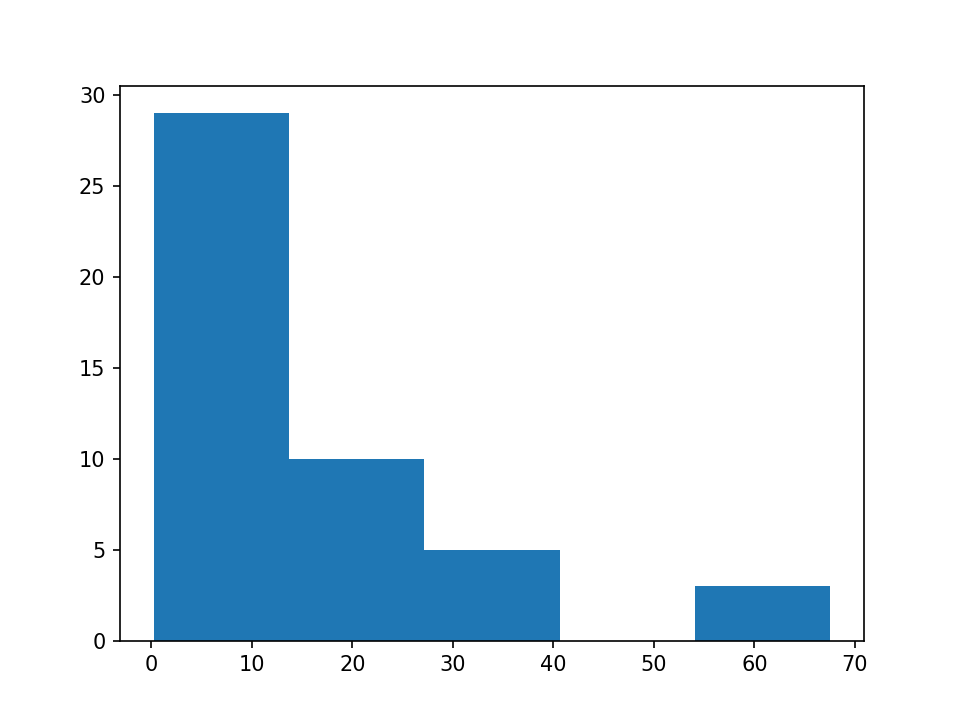

In [10]:
scalar = 1000000
fixedDF = (df[~df['views'].str.contains("N/A", case=False, na=False)]['views'])/scalar
fixedDF = fixedDF.tolist()


plt.hist(fixedDF, bins = 5 )


plt.show()

# Further Ideas
If you are interested in doing this yourself, here are some sites with laxer robots.txt that could be interesting to scrape (read as: these were my other tutorial example ideas)
- Wikipedia
- Bulbapedia
- Fandom.com
- Stackoverflow
- Sparknotes.com
- artsandculture.google.com
- Some clothing ecommerce sites (American Eagle, Urban Outfitters, Forever21)

# References
Scrapy documentation and intro tutorial
https://docs.scrapy.org/en/latest/intro/tutorial.html

Scrapy item pipeline documentation
https://doc.scrapy.org/en/latest/topics/item-pipeline.html

Yield explanation
https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

Robots.txt explanation
https://www.robotstxt.org/robotstxt.html

Scrapy + Jupyter incompatibility issue explanation and code
https://stackoverflow.com/a/44086709
https://stackoverflow.com/a/43015816